<a href="https://colab.research.google.com/github/CrissRMFI/TA047R-2C2024-GRUPO08/blob/main/TA047R_TP1_GRUPO08_ENTREGA_EJ2_Modelos_de_Clasificaci%C3%B3n_Binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EJERCICIO 2 - Modelos de Clasificación Binaria
Grupo 9

---

Integrantes:<br>
  Avalos, Camila Lucia<br>
  Benitez Potochek, Tomás<br>
  Roldan Montes, Cristian<br>
  Sprenger, Roberta

Objetivo del ejercicio: predecir si lloverá o no al día siguiente (variable RainTomorrow), en función de los
datos meteorológicos del día actual, en los siguientes lugares:
*   Queensland
*   Nueva Gales del Sur
*   Terr. de la capital





# Análisis Exploratorio y preprocesamiento de datos

Cargamos desde una fuente externa el archivo que vamos a utilizar para poder predecir si lloverá

In [ ]:
!wget "https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/Ejercicio%202/weatherAUS.csv";

--2024-10-13 17:29:11--  https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/Ejercicio%202/weatherAUS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14094055 (13M) [text/plain]
Saving to: ‘weatherAUS.csv.2’

weatherAUS.csv.2    100%[===================>]  13.44M  35.3MB/s    in 0.4s    

2024-10-13 17:29:13 (35.3 MB/s) - ‘weatherAUS.csv.2’ saved [14094055/14094055]



Una vez que los cargamos procedemos a ver la información del dataframe y las primeras filas para saber con que datos estamos trabajando y lo que nos resultaria util

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore


#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, classification_report, make_scorer, precision_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


datosTiempo = pd.read_csv(filepath_or_buffer="weatherAUS.csv",sep=",");
datosTiempo.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
datosTiempo.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No


Vemos el porcentaje de valores nulos que contiene cada columna

In [ ]:
print(datosTiempo.isna().sum() / datosTiempo.shape[0] * 100)

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


Escogemos las filas que nos convendria quedarnos, estas son:
*  'Date': Fecha del dia.
*   'Location': Localización.
*   'MinTemp': Temperatura minima del dia.
*   'MaxTemp': Temperatura maxima del dia.
*    'Rainfall': Cantidad de lluvia que cayó.
*   'Humidity3pm' : La humedad que hizo a las 3PM.
*   'Pressure3pm': Presión atmosferica a las 3PM.
*    'RainToday': Si llovió en el dia.
*   'RainTomorrow': Si Lloverá mañana.
*   'WindGustSpeed': La velocidad del viento

In [ ]:
datosTiempo = datosTiempo[['Date','Location','MinTemp','MaxTemp','Rainfall','Humidity3pm','Pressure3pm','RainToday','RainTomorrow','WindGustSpeed']]
datosTiempo.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed
0,2008-12-01,Albury,13.4,22.9,0.6,22.0,1007.1,No,No,44.0
1,2008-12-02,Albury,7.4,25.1,0.0,25.0,1007.8,No,No,44.0
2,2008-12-03,Albury,12.9,25.7,0.0,30.0,1008.7,No,No,46.0
3,2008-12-04,Albury,9.2,28.0,0.0,16.0,1012.8,No,No,24.0
4,2008-12-05,Albury,17.5,32.3,1.0,33.0,1006.0,No,No,41.0


Verificamos que en las columnas 'WindGustSpeed', "Rainfall", "Humidity3pm" y "Pressure3pm" no haya valores negativos ya que no tendria sentido

In [ ]:
ColumnasValoresNegativos = ["Rainfall", "Humidity3pm", "Pressure3pm",'WindGustSpeed']
for fila in ColumnasValoresNegativos:
  print(fila +":")
  print((datosTiempo[fila] < 0).any())

Rainfall:
False
Humidity3pm:
False
Pressure3pm:
False
WindGustSpeed:
False


Como queremos saber a que Estado pertenecen las ciudades adquiridas anteriormente lo que vamos a hacer es obtener un csv que contenga las ciudades y a que estado pertenecen

In [ ]:
!wget "https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/Ejercicio%202/aus_coordinates.xlsx";

--2024-10-13 17:29:14--  https://raw.githubusercontent.com/CrissRMFI/TA047R-2C2024-GRUPO08/refs/heads/main/Ejercicio%202/aus_coordinates.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10899 (11K) [application/octet-stream]
Saving to: ‘aus_coordinates.xlsx.2’

aus_coordinates.xls 100%[===================>]  10.64K  --.-KB/s    in 0.001s  

2024-10-13 17:29:14 (13.9 MB/s) - ‘aus_coordinates.xlsx.2’ saved [10899/10899]



In [ ]:
datosCiudades = pd.read_excel("aus_coordinates.xlsx");
datosCiudades.head(5)

,Region,Location,Coordinates
0,Australia Meridional,Adelaide,"(-34.9285, 138.6007)"
1,Queensland,Albany,"(-35.0275, 117.8847)"
2,Nueva Gales del Sur,Albury,"(-36.0737, 146.9135)"
3,Territorio del Norte,AliceSprings,"(-23.6980, 133.8807)"
4,Nueva Gales del Sur,BadgerysCreek,"(-33.9209, 150.7738)"


Vemos como estan escritos los nombres de los estados que nos interesan, para eso sacamos los valores unicos de la columna "Region"

In [ ]:
datosCiudades.Region.unique()

array(['Australia Meridional', 'Queensland', 'Nueva Gales del Sur',
       'Territorio del Norte', 'Victoria', 'Territorio de la Capital',
       'Tasmania', 'Australia Occidental'], dtype=object)

Filtramos para quedarnos con aquellas filas en las cuales la columna "Región" sea igual a el nombre de los estados que nos interesan a nosotros que son:

*  Queensland
* Nueva Gales del Sur
* Terr. de la capital


In [ ]:
ciudadesBuscadas = datosCiudades.loc[(datosCiudades["Region"] == "Nueva Gales del Sur") | (datosCiudades["Region"] == "Queensland") | (datosCiudades["Region"] == "Territorio de la Capital")];
ciudadesBuscadas = ciudadesBuscadas.dropna(subset = "Location");
ciudadesBuscadas = ciudadesBuscadas.drop("Coordinates", axis = 1)
ciudadesBuscadas.head(2)

,Region,Location
1,Queensland,Albany
2,Nueva Gales del Sur,Albury


Ahora que tenemos una lista con las ciudades que pertenecen a los estados que buscamos, hacemos un inner join con los datos del tiempo inicial, para quedarnos con las filas que nos interesan.

In [ ]:
tiemposBuscados = pd.merge(datosTiempo, ciudadesBuscadas, on = "Location", how = "inner")
tiemposBuscados.Region.unique()

array(['Nueva Gales del Sur', 'Territorio de la Capital', 'Queensland'],
      dtype=object)

In [ ]:
tiemposBuscados.head(3)

,Date,Location,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed,Region
0,2008-12-01,Albury,13.4,22.9,0.6,22.0,1007.1,No,No,44.0,Nueva Gales del Sur
1,2008-12-02,Albury,7.4,25.1,0.0,25.0,1007.8,No,No,44.0,Nueva Gales del Sur
2,2008-12-03,Albury,12.9,25.7,0.0,30.0,1008.7,No,No,46.0,Nueva Gales del Sur


Comprobamos si existen filas duplicadas en el dataSet para poder eliminarlas en caso de ser necesario.

In [ ]:
tiemposBuscados.duplicated().unique()

array([False])

Verificamos el porcentaje de valores nulos que posee cada columna

In [ ]:
print(tiemposBuscados.isna().sum() / tiemposBuscados.shape[0] * 100)

Date              0.000000
Location          0.000000
MinTemp           0.997835
MaxTemp           0.748747
Rainfall          2.292204
Humidity3pm       3.542093
Pressure3pm      14.802953
RainToday         2.292204
RainTomorrow      2.290721
WindGustSpeed    13.385523
Region            0.000000
dtype: float64


Verificamos el porcentaje de información que se borraria del dataset

In [ ]:
CantidadDespuesDeEliminarNulos = tiemposBuscados.dropna(subset = ["RainTomorrow", "RainToday", 'MinTemp', "MaxTemp", "Rainfall", "Humidity3pm", "Pressure3pm",'WindGustSpeed']).shape[0]
print("El porcentaje que se eliminaria seria "+ str((tiemposBuscados.shape[0] - CantidadDespuesDeEliminarNulos) * 100 / tiemposBuscados.shape[0]))

El porcentaje que se eliminaria seria 24.630074429914302


Es un porcentaje significativo. Pero para reducir decisiones basadas en datos que pueden resultar invalidos y teniendo en cuenta que por esto se guian las decisiones tomadas a futuro por los modelos. Se eliminaran los datos nulos.

In [ ]:
datosTiempo = tiemposBuscados.dropna();
datosTiempo.Location.count()

50834

Convertimos las variable categoricas "RainTomorrow" y "RainToday" a variables cuantitativas. Teniendo en cuenta que "Yes" va a ser 1 y "No" va a ser 0

In [ ]:
datosTiempo['RainToday'] = datosTiempo['RainToday'].map({'Yes': 1, 'No': 0})
datosTiempo['RainTomorrow'] = datosTiempo['RainTomorrow'].map({'Yes': 1, 'No': 0})
datosTiempo.head(2)

<ipython-input-98-04bbe3ad09bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosTiempo['RainToday'] = datosTiempo['RainToday'].map({'Yes': 1, 'No': 0})
<ipython-input-98-04bbe3ad09bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datosTiempo['RainTomorrow'] = datosTiempo['RainTomorrow'].map({'Yes': 1, 'No': 0})


,Date,Location,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed,Region
0,2008-12-01,Albury,13.4,22.9,0.6,22.0,1007.1,0,0,44.0,Nueva Gales del Sur
1,2008-12-02,Albury,7.4,25.1,0.0,25.0,1007.8,0,0,44.0,Nueva Gales del Sur


Usamos el One hot encoding para convertir las variables categoricas que vamos a utilizar

In [ ]:
dfEncoding = pd.get_dummies(datosTiempo, columns=['Region'], drop_first=True)
dfEncoding.head(4)

,Date,Location,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed,Region_Queensland,Region_Territorio de la Capital
0,2008-12-01,Albury,13.4,22.9,0.6,22.0,1007.1,0,0,44.0,False,False
1,2008-12-02,Albury,7.4,25.1,0.0,25.0,1007.8,0,0,44.0,False,False
2,2008-12-03,Albury,12.9,25.7,0.0,30.0,1008.7,0,0,46.0,False,False
3,2008-12-04,Albury,9.2,28.0,0.0,16.0,1012.8,0,0,24.0,False,False


In [ ]:
dfEncoding = pd.get_dummies(dfEncoding, columns=['Location'], drop_first=True)
dfEncoding = dfEncoding.drop("Date", axis = 1)
dfEncoding = dfEncoding.astype("float64")
dfEncoding.head(2)

,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed,Region_Queensland,Region_Territorio de la Capital,...,Location_Moree,Location_NorahHead,Location_NorfolkIsland,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_WaggaWagga,Location_Williamtown,Location_Wollongong
0,13.4,22.9,0.6,22.0,1007.1,0.0,0.0,44.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.4,25.1,0.0,25.0,1007.8,0.0,0.0,44.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las variables que vamos a usar para clasificar son todas las del dataset menos la variable target que es la columna 'RainTomorrow'

In [ ]:
atributos = dfEncoding.drop(["RainTomorrow"], axis = 1).columns
target = 'RainTomorrow'
dataSet_x = dfEncoding[atributos]
dataSet_y = dfEncoding[target].copy()

In [ ]:
dfEncoding[target].value_counts(normalize=True)*100

,proportion
RainTomorrow,
0.0,77.611441
1.0,22.388559


  Generamos los conjuntos de train y test. El conjunto de datos de test será del 20%

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataSet_x.values,
                                                    dataSet_y.values,
                                                    test_size=0.2,
                                                    random_state=13,
                                                    stratify = dataSet_y.values)

In [ ]:
x_train.shape

(40667, 26)

In [ ]:
y_train.shape

(40667,)

Verificamos la distribución de casos positivos en los test de prueba y entramiento

In [ ]:
for split_name, split in zip(['% Casos positivos entrenamiento','% casos positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

% Casos positivos entrenamiento: 22.389
% casos positivos Prueba: 22.386


# Arbol de decisión

Buscamos los hiperparamatros para saber cuales son los mejores para la creación de un arbol de decisión. En este caso utilizamos como número de folds = 15, ya que se probó con 10, pero la metrica de F1 es más alta con 15.<br>
Como la muestra esta desbalanceada, utilizamos la metrica F1 Score ya que considera el recall y la precisión.<br>
Decidimos usar RandomizedSearchCV ya que proporciona un mayor control a la hora de buscar hiperparametros debido a que le podemos limitar el número de iteraciones que queremos que haga y comprende un espectro más amplio a la hora de considerar posibles combinacones de hiperparametros. Se probró con Grid Search, pero despues de 5hs todavia no habia encontrado un resultado, entonces se considero que el coste computacional que supone es mayor al resultado que se obtendría.
Para saber que se eligió la mejor combinación posible, se harán 10 iteraciones del randomSearch y se quedará con el mejor resultado.

In [ ]:
parametros = {'criterion':['gini','entropy'],
              'min_samples_split': list(range(4,21)),
              'min_samples_leaf': list(range(2,20)),
              'ccp_alpha':np.linspace(0,0.05,15),
              'max_depth':list(range(1,21)),
              'max_features': [0.5, 0.6, 0.7, 0.8, 0.9]}
numeroFolds=15
kFold = StratifiedKFold(n_splits=numeroFolds)
arbolBase = DecisionTreeClassifier(random_state=13, class_weight ="balanced")
scorer = make_scorer(f1_score)

In [ ]:
mejorScore = 0
mejoresHiperparametros = {}
for i in range(15):
  randomCvF1= RandomizedSearchCV(estimator=arbolBase,
                              param_distributions = parametros,
                              scoring=scorer,
                              cv=kFold,
                              n_iter=numeroFolds,
                              )
  arbolCv = randomCvF1.fit(x_train,y_train);
  if arbolCv.best_score_ > mejorScore:
    print(arbolCv.best_score_)
    print(mejorScore)
    mejorScore = arbolCv.best_score_
    mejoresHiperparametros = arbolCv.best_params_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.5671177449751342
0
0.5909425993452717
0.5671177449751342
0.5909688441835804
0.5909425993452717
0.5931508093894847
0.5909688441835804


In [ ]:
parametrosBuscadosF1 = mejoresHiperparametros
print("Los hiperparametros por F1 score son: ")
print(parametrosBuscadosF1)
print("La mejor metrica en F1 fue: ")
print(mejorScore)

Los hiperparametros por F1 score son: 
{'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 0.7, 'max_depth': 10, 'criterion': 'entropy', 'ccp_alpha': 0.0}
La mejor metrica en F1 fue: 
0.5931508093894847


In [ ]:
arbolF1 = DecisionTreeClassifier(class_weight='balanced',random_state=13).set_params(**parametrosBuscadosF1)
arbolF1 = arbolF1.fit(x_train,y_train)
arbolF1

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=0.7, min_samples_leaf=8,
                       min_samples_split=15, random_state=13)

In [ ]:
arbolF1.classes_

array([0., 1.])

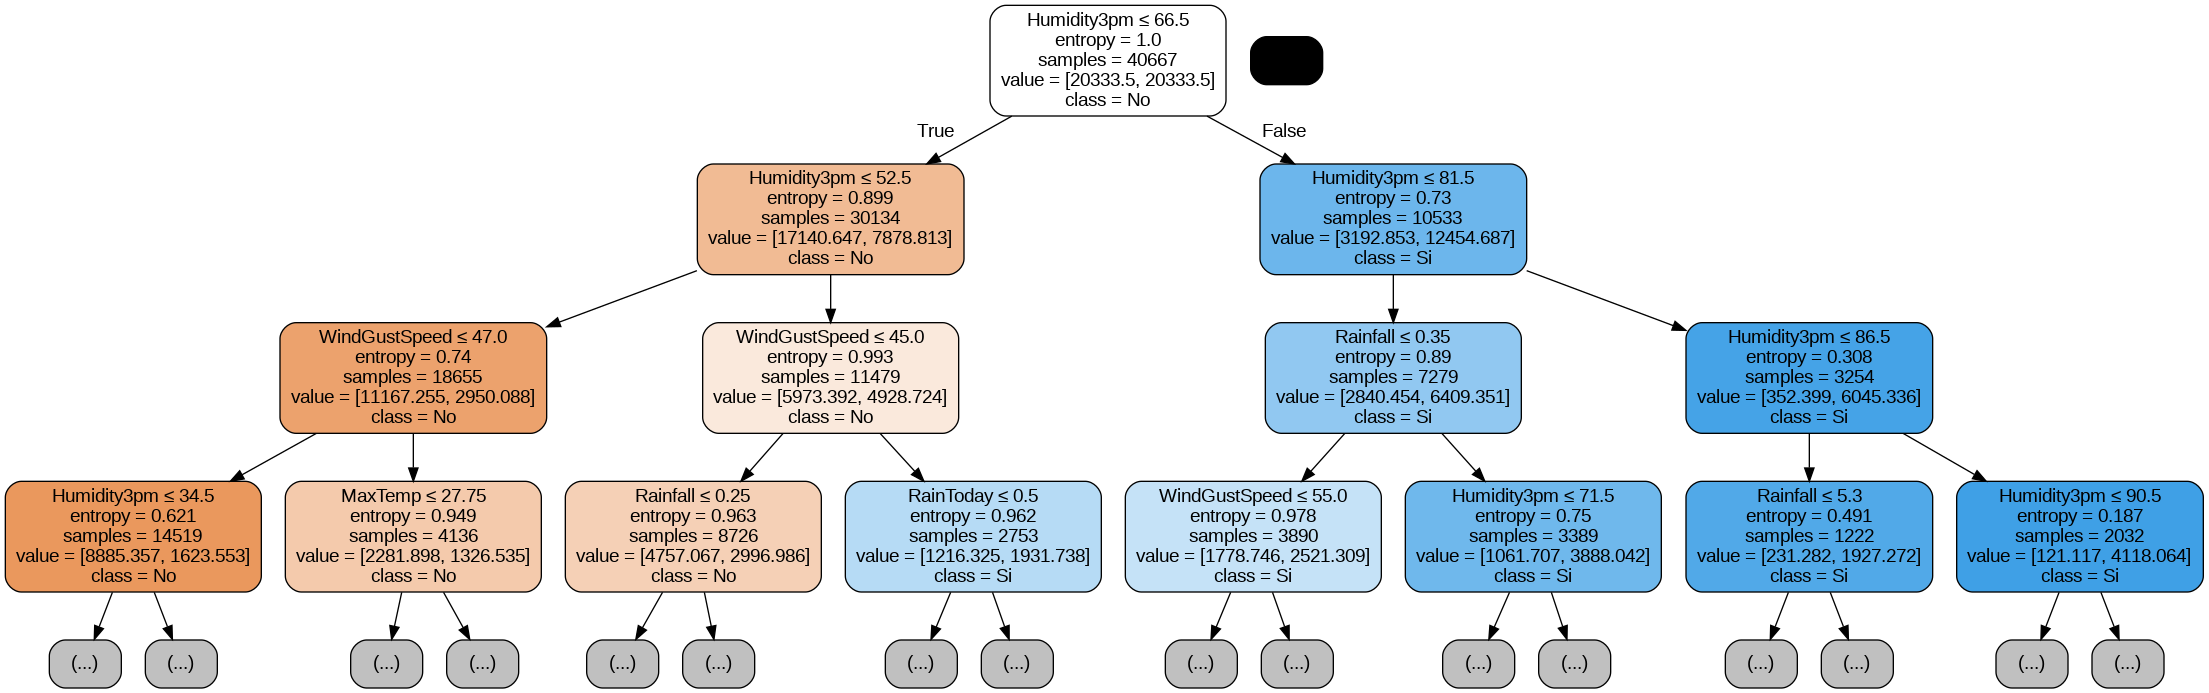

In [ ]:
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(arbolF1, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=atributos,
                class_names=["No", "Si"],
                max_depth= 3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

El arbol que graficamos anteriormente quiere decir que:


*   Si la humedad es más chica o igual que 66.5 probablemente no llueva.
  *  Si la humedad es más chica o igual que 52.5 y la velocidad del viento es menor que 47 probablemente no llueva.
    * Sin embargo si en el día se dijo que podia llover y la velocidad del viento es menor a 45 podria llover.

  Ahora es probable que al dia siguiente llueva si:
*   La humedad esta entre 66.5 y 90.5 es muy probable que llueva.
    *  Si la humedad esta entre 66.5 y 81.5 y en el día la caida de lluvia fue menor a 0.35. Es probable que llueva al dia siguiente.
    *  Si la condición anterior se cumple y la velocidad del viento es menor a 55 o la humedad es menor a 71.5 sigue siendo probable que llueva al dia siguiente.



Matriz de confusión y metricas respecto al set de evaluación

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86      7891
         1.0       0.52      0.69      0.59      2276

    accuracy                           0.79     10167
   macro avg       0.71      0.75      0.73     10167
weighted avg       0.82      0.79      0.80     10167

Accuracy: 0.7896134552965477
Recall: 0.6902460456942003
Precisión: 0.5227953410981697
f1 Score: 0.5949630751751562


Text(50.722222222222214, 0.5, 'Real')

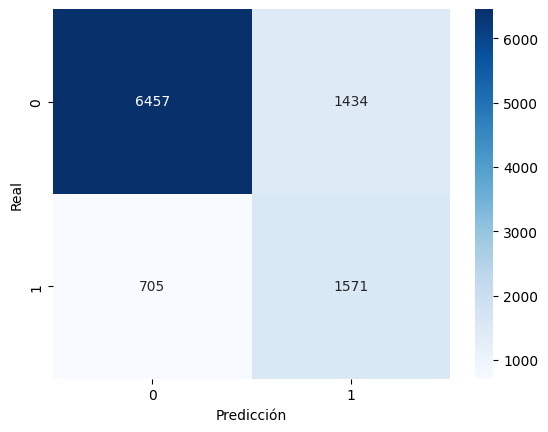

In [ ]:
y_pred= arbolF1.predict(x_test)
print(classification_report(y_test,y_pred))

arbolAccuracy=accuracy_score(y_test,y_pred)
arbolRecall=recall_score(y_test,y_pred)
arbolF1score=f1_score(y_test,y_pred,)
arbolPrecision=precision_score(y_test,y_pred)

print("Accuracy: "+str(arbolAccuracy))
print("Recall: "+str(arbolRecall))
print("Precisión: "+str(arbolPrecision))
print("f1 Score: "+str(arbolF1score))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

Matriz de confusión y metricas respecto al set de entrenamiento

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     31562
         1.0       0.57      0.76      0.65      9105

    accuracy                           0.82     40667
   macro avg       0.74      0.79      0.76     40667
weighted avg       0.84      0.82      0.82     40667

Accuracy: 0.8152310226965352
Recall: 0.7578253706754531
Precisión: 0.5651568515029896
f1 Score: 0.6474617622220137


Text(50.722222222222214, 0.5, 'Real')

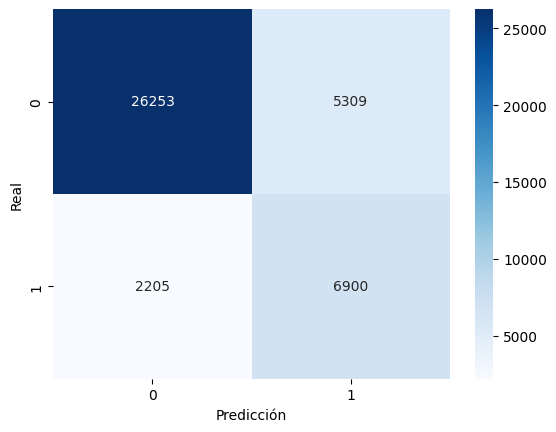

In [ ]:
y_pred= arbolF1.predict(x_train)
print(classification_report(y_train,y_pred))


accuracy=accuracy_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
f1=f1_score(y_train,y_pred,)
precision=precision_score(y_train,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precisión: "+str(precision))
print("f1 Score: "+str(f1))


cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Random Forest

Hallamos los mejores hiperparametros mediante cross validation.<br>
Utilizamos F1 ya que los datos estaban desbalanceados.<br>
Ya que no utilizamos GridSearch debido al coste computacional, consideramos adecuado usar 15 folds en vez de 5 o 10. No más porque el resultado no variaba mucho.
Para compesar el hecho que no se prueban todos los resultados posibles, se realizará una iteración y nos quedaremos con el mejor resultado

In [ ]:
parametros = {'criterion':['gini','entropy'],
              'min_samples_split': list(range(2,15)),
              'min_samples_leaf': list(range(2,15)),
              'ccp_alpha':np.linspace(0,0.05,20),
              'max_depth':list(range(1,10)),
              'n_estimators': list(range(10,100,10)),}
numeroFolds=15
kFold = StratifiedKFold(n_splits=numeroFolds)
forestBase = RandomForestClassifier(random_state=13, class_weight ="balanced", oob_score =True)
scorer = make_scorer(f1_score)
mejorScore = 0
mejoresHiperparametros = {}
for i in range(5):
  randomCvF1= RandomizedSearchCV(estimator=forestBase,
                              param_distributions = parametros,
                              scoring=scorer,
                              cv=kFold,
                              n_iter=numeroFolds,
                              n_jobs=-1,
                              )
  arbolForest = randomCvF1.fit(x_train,y_train);
  if arbolForest.best_score_ > mejorScore:
    print("El mejor resultado ahora es: " + str(arbolForest.best_score_))
    print("El mejor resultado antes era: " + str(mejorScore))
    mejorScore = arbolForest.best_score_
    mejoresHiperparametros = arbolForest.best_params_


El mejor resultado ahora es: 0.5638309673482048
El mejor resultado antes era: 0
El mejor resultado ahora es: 0.5984194380870032
El mejor resultado antes era: 0.5638309673482048


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [ ]:
parametrosBuscadosF1 = mejoresHiperparametros
print("Los hiperparametros por F1 score son: ")
print(parametrosBuscadosF1)
print("La mejor metrica en F1 fue: ")
print(mejorScore)

Los hiperparametros por F1 score son: 
{'n_estimators': 30, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_depth': 7, 'criterion': 'gini', 'ccp_alpha': 0.0}
La mejor metrica en F1 fue: 
0.5984194380870032


In [ ]:
forestF1 = RandomForestClassifier(random_state=13, class_weight ="balanced", oob_score =True).set_params(**parametrosBuscadosF1)
forestF1 = forestF1.fit(x_train,y_train)

Importancia de los atributos

In [ ]:
sorted(list(zip(atributos, forestF1.feature_importances_)), key=lambda x: -x[1])

[('Humidity3pm', 0.47331106540367623),
 ('RainToday', 0.18125439467485538),
 ('Rainfall', 0.11281805890235527),
 ('WindGustSpeed', 0.08094348494807337),
 ('MinTemp', 0.05159301491849126),
 ('MaxTemp', 0.03511500435268308),
 ('Pressure3pm', 0.03470539276851174),
 ('Location_Moree', 0.0036436773955827997),
 ('Location_NorfolkIsland', 0.003456967300990293),
 ('Location_NorahHead', 0.0031194240997299756),
 ('Location_Wollongong', 0.0028711768514029603),
 ('Location_Cobar', 0.0025613654262902786),
 ('Location_Cairns', 0.0022730468998088857),
 ('Location_CoffsHarbour', 0.002032090875728882),
 ('Region_Queensland', 0.0020286930153455077),
 ('Location_Townsville', 0.001936657975086558),
 ('Region_Territorio de la Capital', 0.0015034833009875926),
 ('Location_Brisbane', 0.0012392065492717224),
 ('Location_WaggaWagga', 0.0006819871917216088),
 ('Location_Canberra', 0.0006633679048652338),
 ('Location_Tuggeranong', 0.000504208325485001),
 ('Location_BadgerysCreek', 0.0005022508212242341),
 ('Loca

Como se puede observar los atributos más importantes son la predicción de

1.   La humedad en el ambiente a las 3PM
2.   La probabilidad de lluvia en el dia.
3.   La cantidad de lluvia que cayo en el día
4.   La velocidad del viento.
5.   El minimo de temperatura.

los menos importantes son los relacionados con la localidad

Graficamos el mejor arbol de predicción del Random Forest

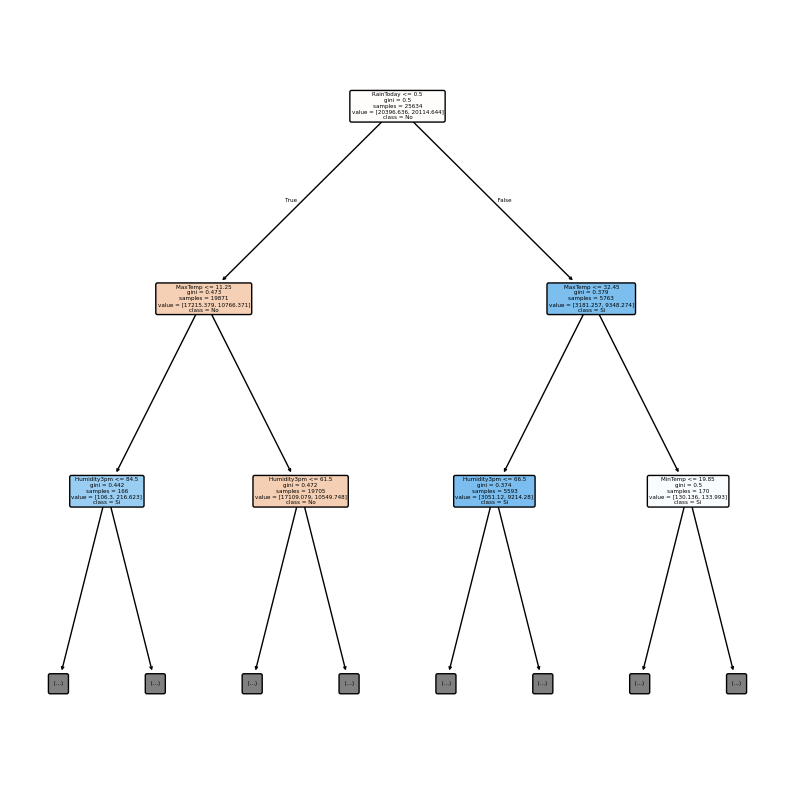

In [ ]:
from sklearn.tree import plot_tree
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

plt.figure(figsize=(10,10))

tree_plot_completo=tree.plot_tree(forestF1.estimators_[0],
                                 feature_names=atributos,
                                 filled=True,
                                 rounded=True,
                                 class_names=["No", "Si"],
                                 max_depth=2)
plt.show(tree_plot_completo)

Ahora realizamos la matriz de confusion respecto al set de evaluación y evaluamos las metricas principales

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      7891
         1.0       0.51      0.72      0.60      2276

    accuracy                           0.78     10167
   macro avg       0.71      0.76      0.73     10167
weighted avg       0.82      0.78      0.80     10167

Accuracy: 0.7842037965968329
Recall: 0.7240773286467487
Precisión: 0.5127566894835096
f1 Score: 0.6003642987249544


Text(50.722222222222214, 0.5, 'Real')

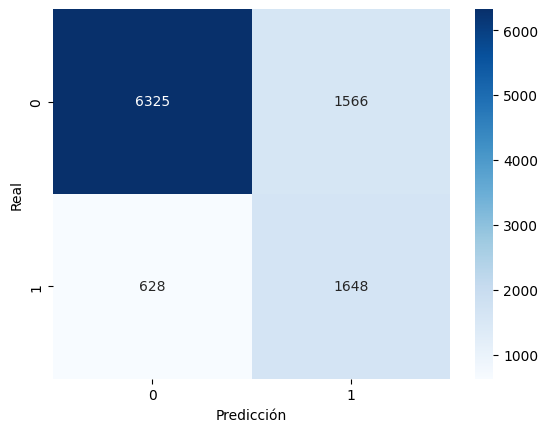

In [ ]:
y_pred= forestF1.predict(x_test)
print(classification_report(y_test,y_pred))

forestAccuracy=accuracy_score(y_test,y_pred)
forestRecall=recall_score(y_test,y_pred)
forestF1score=f1_score(y_test,y_pred,)
forestPrecision=precision_score(y_test,y_pred)

print("Accuracy: "+str(forestAccuracy))
print("Recall: "+str(forestRecall))
print("Precisión: "+str(forestPrecision))
print("f1 Score: "+str(forestF1score))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

Hacemos lo mismo con el set de entrenamiento

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     31562
         1.0       0.52      0.74      0.61      9105

    accuracy                           0.79     40667
   macro avg       0.72      0.77      0.73     40667
weighted avg       0.83      0.79      0.80     40667

Accuracy: 0.7881082941943098
Recall: 0.7406919275123558
Precisión: 0.5187692307692308
f1 Score: 0.6101786926034833


Text(50.722222222222214, 0.5, 'Real')

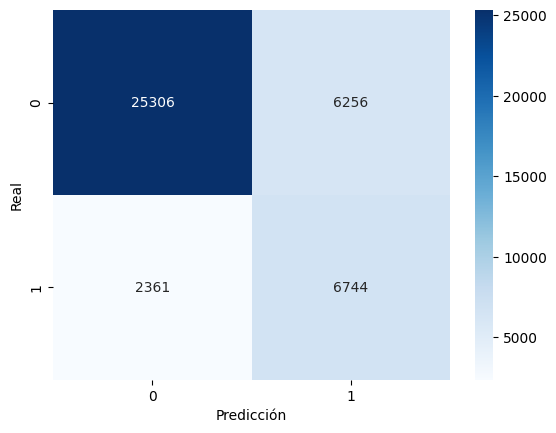

In [ ]:
y_pred= forestF1.predict(x_train)
print(classification_report(y_train,y_pred))

accuracy=accuracy_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
f1=f1_score(y_train,y_pred,)
precision=precision_score(y_train,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precisión: "+str(precision))
print("f1 Score: "+str(f1))

cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

# SVM

Como para SVM es importante que los datos tengan una desviación estandar unitaria, vamos a normalizar las columnas que tengan valores numericos. Para ello nos vamos a fijar los outliners

In [ ]:
columnasNumericas = ['MinTemp','MaxTemp','Rainfall','Humidity3pm','Pressure3pm','WindGustSpeed']
for columna in columnasNumericas:
  z_scores = zscore(dfEncoding[columna])
  abs_z_scores = np.abs(z_scores)
  outliers = dfEncoding[abs_z_scores > 3]
  print(columna + " número de outliers:"+ str(len(outliers)))

MinTemp número de outliers:35
MaxTemp número de outliers:83
Rainfall número de outliers:939
Humidity3pm número de outliers:0
Pressure3pm número de outliers:150
WindGustSpeed número de outliers:495


Text(0.5, 0, 'Temperaturas')

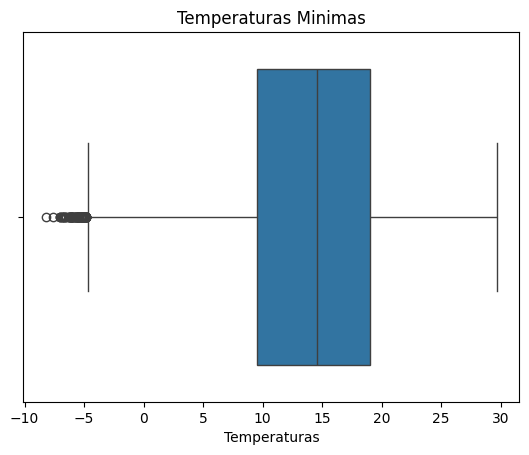

In [ ]:
grafico = sns.boxplot(data = dfEncoding, x = 'MinTemp')
grafico.set_title('Temperaturas Minimas')
grafico.set_xlabel('Temperaturas')

Text(0.5, 0, 'Temperaturas')

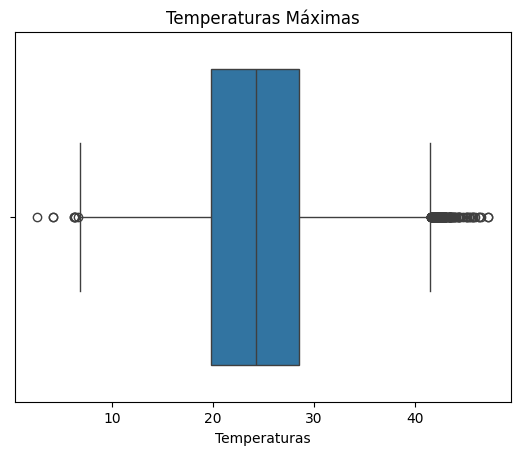

In [ ]:
grafico = sns.boxplot(data = dfEncoding, x = 'MaxTemp')
grafico.set_title('Temperaturas Máximas')
grafico.set_xlabel('Temperaturas')

Text(0.5, 0, 'Cantidad de precipitación')

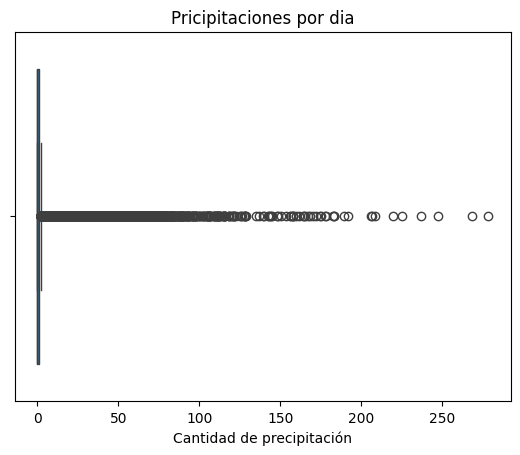

In [ ]:
grafico = sns.boxplot(data = dfEncoding, x = 'Rainfall')
grafico.set_title('Pricipitaciones por dia')
grafico.set_xlabel('Cantidad de precipitación')

In [ ]:
atributos = dfEncoding.columns
target = 'RainTomorrow'
dataSet_x = dfEncoding[atributos]
dataSet_y = dfEncoding[target].copy()

In [ ]:
Creamos los conjuntos de entranamiento y test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(dataSet_x,
                                                    dataSet_y,
                                                    test_size=0.2,
                                                    random_state=13,
                                                    stratify = dataSet_y)

In [ ]:
x_train.shape
x_train.head(2)

,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,RainToday,RainTomorrow,WindGustSpeed,Region_Queensland,Region_Territorio de la Capital,...,Location_Moree,Location_NorahHead,Location_NorfolkIsland,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_WaggaWagga,Location_Williamtown,Location_Wollongong
6694,7.5,22.4,0.0,28.0,1021.2,0.0,0.0,39.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62132,25.6,32.4,0.0,64.0,1001.2,0.0,0.0,33.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
y_train.shape

(40667,)

Normalizamos las columnas numericas en los conjustos x de test y entrenamiento

In [ ]:
scaler = StandardScaler()
x_trainEscalado = x_train[columnasNumericas]
x_testEscalado= x_test[columnasNumericas]
x_trainEscalado=  scaler.fit_transform(x_trainEscalado)
x_testEscalado=  scaler.fit_transform(x_testEscalado)

x_trainEscalado.shape, x_testEscalado.shape

((40667, 6), (10167, 6))

In [ ]:
x_trainNorm= pd.DataFrame(x_trainEscalado, columns=columnasNumericas)
x_testNorm = pd.DataFrame(x_testEscalado, columns=columnasNumericas)
x_trainNorm.head(2)

,MinTemp,MaxTemp,Rainfall,Humidity3pm,Pressure3pm,WindGustSpeed
0,-0.981326,-0.298912,-0.277097,-1.306051,0.920206,0.002450
1,1.799937,1.351458,-0.277097,0.531051,-2.164299,-0.449055


Unimos los conjuntos de entremiento y test con las columnas que no se debian normalizar ya que eran valores de one hot encoding y no hacia falta que se escalen

In [ ]:
x_trainFinal = pd.concat([x_trainNorm.reset_index(drop=True) ,x_train.drop(columnasNumericas, axis = 1).reset_index(drop=True)], axis=1)
x_testFinal = pd.concat([x_testNorm.reset_index(drop=True), x_test.drop(columnasNumericas, axis = 1).reset_index(drop=True)], axis=1)
x_trainFinal.shape, x_testFinal.shape,

((40667, 27), (10167, 27))

Establecemos parametros para realizar K-Cross validation. Se uso 5 folds ya que se probo con 10 pero el tiempo de respuesta superaba las 3hs y los resultados no diferian. Se uso RandomSearch para disminuir los costes computacionales

In [ ]:
parametros = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': np.linspace(0.001,10,15),
              'gamma': ['scale', 'auto'] + list(np.linspace(0.01, 2, 10)),
              'degree':[2, 3, 4],
              'coef0':np.linspace(-1,3,10)
              }
numeroFolds = 5
scorer = make_scorer(f1_score)

In [ ]:
from sklearn.svm import SVC
kFold = StratifiedKFold(n_splits=numeroFolds)
BaseSVM= SVC(random_state=13, class_weight= "balanced")
scorer = make_scorer(f1_score)
randomCvF1= RandomizedSearchCV(estimator=BaseSVM,
                              param_distributions = parametros,
                              scoring=scorer,
                              cv=kFold,
                              n_jobs=-1,
                              n_iter=numeroFolds
                              )

RandomSVM= randomCvF1.fit(x_trainFinal,y_train)
mejorScore = RandomSVM.best_score_
mejoresHiperparametros = RandomSVM.best_params_

In [ ]:
parametrosBuscadosF1 = mejoresHiperparametros
print("Los hiperparametros por F1 score son: ")
print(parametrosBuscadosF1)
print("La mejor metrica en F1 fue: ")
print(mejorScore)

Los hiperparametros por F1 score son: 
{'kernel': 'linear', 'gamma': 'auto', 'degree': 2, 'coef0': -0.11111111111111116, 'C': 7.857357142857144}
La mejor metrica en F1 fue: 
1.0


In [ ]:
SVCF1 = SVC(random_state=13, class_weight= "balanced").set_params(**parametrosBuscadosF1)
SVCF1 = SVCF1.fit(x_trainFinal,y_train)

Matriz de confusion en base a los datos de evaluación

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7891
         1.0       1.00      1.00      1.00      2276

    accuracy                           1.00     10167
   macro avg       1.00      1.00      1.00     10167
weighted avg       1.00      1.00      1.00     10167

Accuracy: 1.0
Recall: 1.0
Precisión: 1.0
f1 Score: 1.0


Text(50.722222222222214, 0.5, 'Real')

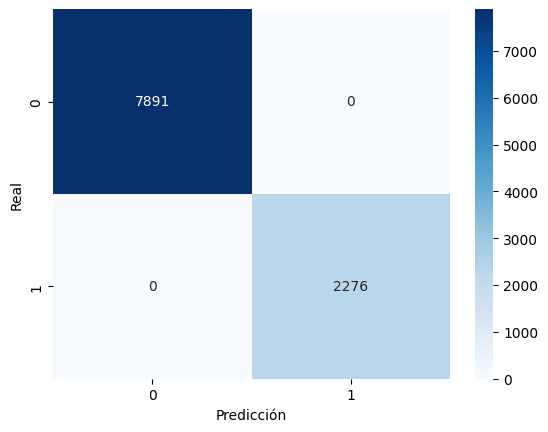

In [ ]:
y_pred= SVCF1.predict(x_testFinal)
print(classification_report(y_test,y_pred))

SVCAccuracy=accuracy_score(y_test,y_pred)
SVCRecall = recall_score(y_test,y_pred)
SVCF1score=f1_score(y_test,y_pred,)
SVCPrecision=precision_score(y_test,y_pred)

print("Accuracy: "+str(SVCAccuracy))
print("Recall: "+str(SVCRecall))
print("Precisión: "+str(SVCPrecision))
print("f1 Score: "+str(SVCF1score))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

In [ ]:
y_pred, y_test

(array([0., 1., 0., ..., 0., 0., 0.]), array([0., 1., 0., ..., 0., 0., 0.]))

Matriz de confusion en base a los datos de entrenamiento

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31562
         1.0       1.00      1.00      1.00      9105

    accuracy                           1.00     40667
   macro avg       1.00      1.00      1.00     40667
weighted avg       1.00      1.00      1.00     40667

Accuracy: 1.0
Recall: 1.0
Precisión: 1.0
f1 Score: 1.0


Text(50.722222222222214, 0.5, 'Real')

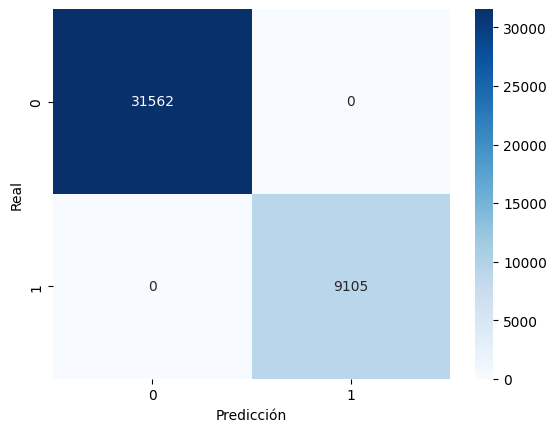

In [ ]:
y_pred= SVCF1.predict(x_trainFinal)
print(classification_report(y_train,y_pred))

accuracy=accuracy_score(y_train,y_pred)
recall=recall_score(y_train,y_pred)
f1=f1_score(y_train,y_pred,)
precision=precision_score(y_train,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precisión: "+str(precision))
print("f1 Score: "+str(f1))

cm = confusion_matrix(y_train,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Comparativa de resultados

In [ ]:
precisiones = [arbolPrecision, forestPrecision, SVCPrecision]
accuracies = [arbolAccuracy, forestAccuracy, SVCAccuracy]
F1s = [arbolF1score, forestF1score, SVCF1score]
recalls = [arbolRecall, forestRecall, SVCRecall]

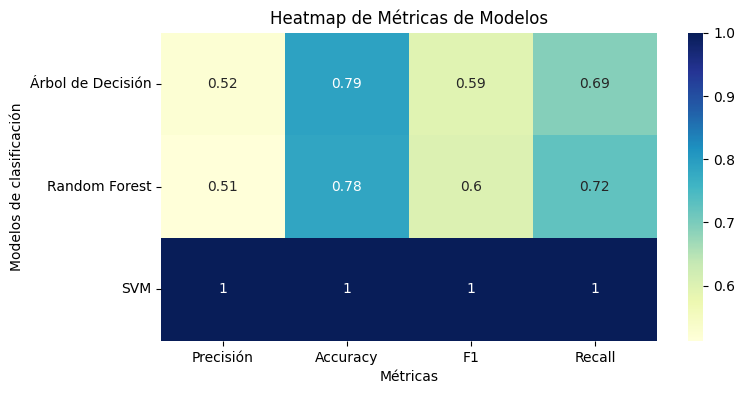

In [ ]:
metricas = {
    'Precisión' : [arbolPrecision, forestPrecision, SVCPrecision],
    'Accuracy' : [arbolAccuracy, forestAccuracy, SVCAccuracy],
   'F1' : [arbolF1score, forestF1score, SVCF1score],
    'Recall' : [arbolRecall, forestRecall, SVCRecall]
}

modelos = ['Árbol de Decisión', 'Random Forest', 'SVM']
df = pd.DataFrame(metricas, index=modelos)
plt.figure(figsize=(8, 4))
sns.heatmap(df, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Heatmap de Métricas de Modelos')
plt.xlabel('Métricas')
plt.ylabel('Modelos de clasificación')
plt.show()

Como el objetivo es predecir si llovera o no, eligiría SVM ya que sus metricas dieron el máximo